# *Notebook pour l'entraînement des modèles de Machine Learning*

## Import des librairies

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings

# Ignorer les avertissements spécifiques de scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


Mounted at /content/drive


In [2]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 5.9 MB/s eta 0:00:00


In [3]:
%reload_ext autoreload
%autoreload 2

import gc
import random

# numpy et pandas pour la manipulation du data
import numpy as np
import pandas as pd

# sklearn
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing, model_selection, linear_model, metrics, impute, ensemble
from sklearn.svm import LinearSVC

from lightgbm import LGBMClassifier

import shap
shap.initjs()

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# hyperopt
from hyperopt import fmin, tpe, hp, anneal, Trials, space_eval

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour tracer les graphes
import matplotlib.pyplot as plt

#autres librairies
import missingno as msno


from sklearn.model_selection import train_test_split, KFold, StratifiedKFold,GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score,precision_score, f1_score, accuracy_score, precision_recall_curve, roc_curve,auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [4]:
# Réglage des graphiques
plt.style.use('seaborn-whitegrid')

plt.rc('font', size=12)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)

dims_fig = (25,35)

## Chargement des données

On recupère le jeu de données sauvegardé à la fin de l'analyse et de la manipulation des données

In [5]:
# Spécifiez le chemin du fichier CSV dans votre Google Drive
path = '/content/drive/MyDrive/openclass/merge.csv'

# Chargez le fichier CSV dans un DataFrame
data = pd.read_csv(path)
data

,index,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON
0,5021,105873,Cash loans,F,Y,Y,0,157500.0,354276.0,20466.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.039499,0.444569,157500.00
1,44110,422056,Cash loans,F,Y,Y,1,112500.0,104256.0,11358.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.032670,1.079075,56250.00
2,50065,157956,Cash loans,F,Y,Y,1,112500.0,312768.0,16506.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173586,0.359692,37500.00
3,58491,167797,Cash loans,M,N,Y,1,360000.0,540000.0,33165.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.144323,0.666667,120000.00
4,47421,446652,Cash loans,F,N,Y,1,135000.0,457312.5,36261.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.149103,0.295203,45000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6121,35531,360124,Cash loans,M,N,N,2,157500.0,296280.0,23539.5,...,0.0,0.0,0.0,0.0,1.0,1.0,NaN,0.154092,0.531592,39375.00
6122,65471,175927,Cash loans,M,Y,N,0,337500.0,808650.0,26086.5,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.009514,0.417362,168750.00
6123,23622,127489,Cash loans,M,N,Y,0,157500.0,560664.0,21852.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.117085,0.280917,157500.00
6124,965,101115,Cash loans,M,Y,Y,1,202500.0,266652.0,14593.5,...,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.030632,0.759417,67500.00


In [6]:
# Supprimer les lignes avec des valeurs manquantes (NaN) dans le DataFrame d'origine
data.dropna(inplace=True)


Modélisation et évaluation des modèles
Dans cette partie, on va entraîner différents modèles de classification binaire et les évaluer.

On va rentrer plusieurs critères d'évaluation dans un tableau, que l'on analysera à la fin pour déterminer le modèle à choisir.

Ces critères sont par exemple :

Le temps d'entraînement : temps nécessaire pour l'entraînement du modèle
Le temps de prédiction : temps nécessaire pour prédire une valeur
Certaines métriques : f1_score, accuracy, precision, recall, AUC
Une métrique personnalisée (voir plus loin)

In [7]:
results = {}

#Modèle Dummy regressor

Le DummyRegressor est une classe qui permet de créer un modèle de régression très simple utilisé comme point de référence ou de comparaison avec d'autres modèles plus complexes. Il s'agit d'un modèle basé sur des règles simples pour la prédiction, et il est principalement utilisé pour évaluer la performance d'autres modèles de régression.

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split  # Importez train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


X = data.drop('TARGET', axis=1)
y = data['TARGET']

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créez un Dummy Regressor
dummy_regressor = DummyRegressor(strategy='mean')

# Entraînez le modèle sur l'ensemble d'entraînement
dummy_regressor.fit(X_train, y_train)

# Faites des prédictions sur l'ensemble de test
y_pred = dummy_regressor.predict(X_test)

# Calculez la métrique (par exemple, Mean Squared Error) pour évaluer la baseline
mse_baseline = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error (Baseline): {mse_baseline}')


Mean Squared Error (Baseline): 0.03590733528285285


In [9]:
# Supprimer toutes les lignes avec des valeurs NaN
data_cleaned = data.dropna()

# Convertir les variables catégorielles en variables indicatrices (one-hot encoding)
data_cleaned = pd.get_dummies(data_cleaned)

# On restreint les colonnes auxquelles vous souhaitez appliquer le modèle
X = data_cleaned.drop(columns=['TARGET'])
y = data_cleaned['TARGET']



On utilise la méthode smote car les données sont imbalanced (la méthode doit être intégré lors du training avec CV + gridsearch) et non à part. Sinon le rééquilibrage des données n'est pas bon. Il faut utiliser un pipeline fourni par imblearn car celui de sickit learn n’intègre pas la méthode smote.

In [10]:

# Importation des bibliothèques
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

# Division des données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création d'un pipeline avec SMOTE pour l'équilibrage des classes
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42))  # Utilisation de SMOTE pour équilibrer les classes
])

# Paramètres pour la grille de recherche des hyperparamètres
param_grid = {
    'smote__sampling_strategy': [0.5, 0.75, 1.0],  # Différentes stratégies d'échantillonnage pour SMOTE
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # Différents noyaux pour le SVM
    'classifier__C': [0.1, 1, 10],  # Paramètre de régularisation C pour le SVM
}

# Initialisation de la grille de recherche avec le pipeline
grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)  # Utilisation de GridSearchCV pour la recherche des meilleurs hyperparamètres


On va tester un modèle linéaire, non linéaire, arbre, ensembliste (logistic, svm, RF et XGBClassifier)


Précision (Precision) : C'est la proportion de prédictions positives correctes parmi toutes les prédictions positives. Dans le contexte des prêts, une haute précision signifie que lorsque le modèle prédit que le client est éligible pour un prêt, il a raison la plupart du temps.

Rappel (Recall) : C'est la proportion de clients éligibles pour un prêt que le modèle a correctement identifiés. Un rappel élevé signifie que le modèle capture un grand pourcentage de clients qui sont réellement éligibles.

Score F1 : C'est la moyenne pondérée de la précision et du rappel. Il est utile lorsque les classes sont déséquilibrées.

Exactitude (Accuracy) : C'est la proportion de prédictions correctes parmi toutes les prédictions. Cependant, l'exactitude peut être trompeuse si les classes sont déséquilibrées.

Le score métier est conçu pour refléter la pertinence du modèle par rapport aux objectifs métier spécifiques. En général, ce score prend en compte les conséquences des faux positifs et des faux négatifs.

Faux positif (FP) : Le modèle prédit que le client est éligible pour un crédit, mais en réalité, il ne l'est pas. Cela pourrait entraîner un risque financier pour la société.

Faux négatif (FN) : Le modèle prédit que le client n'est pas éligible, mais en réalité, il l'est. Cela pourrait signifier la perte d'une opportunité de prêt.

Le coût d’un FN est dix fois supérieur au coût d’un FP


In [11]:
# Importation des bibliothèques nécessaires
from xgboost import XGBClassifier  # Pour XGBoost
from sklearn.metrics import confusion_matrix, make_scorer  # Pour les métriques
from sklearn.model_selection import GridSearchCV  # Pour la recherche des hyperparamètres
from imblearn.pipeline import Pipeline  # Pour la pipeline
from imblearn.over_sampling import SMOTE  # Importation de la classe SMOTE
import numpy as np  # Pour les calculs numériques

# Fonction pour trouver le meilleur seuil de classification
def find_best_threshold(y, y_pred_prob):
    scores = np.array([])  # Création d'un tableau vide pour stocker les scores
    for threshold in np.arange(0, 1, 0.1):  # Itération sur les seuils de 0 à 1 avec un pas de 0.1
        y_pred = y_pred_prob > threshold  # Prédiction à partir du seuil
        mat_conf = confusion_matrix(y, y_pred)  # Calcul de la matrice de confusion
        tn = mat_conf[0, 0]  # Vrais négatifs
        fn = mat_conf[1, 0]  # Faux négatifs
        fp = mat_conf[1, 1]  # Faux positifs
        score = 10 * fp + 1 * fn  # Calcul du score métier
        scores = np.append(scores, score)  # Ajout du score au tableau
    best_score = scores.max()  # Meilleur score
    best_threshold = np.arange(0, 1, 0.1)[np.argmax(scores)]  # Seuil correspondant au meilleur score
    return best_score, best_threshold

# Fonctions pour calculer le score métier et le seuil métier
def score_metier(y, y_pred_prob):
    best_score, _ = find_best_threshold(y, y_pred_prob)
    return best_score

def seuil_metier(y, y_pred_prob):
    _, best_threshold = find_best_threshold(y, y_pred_prob)
    return best_threshold

# Dictionnaire des scores pour la recherche des hyperparamètres
scoring = {
    "Score métier": make_scorer(score_metier, needs_proba=True, greater_is_better=False),  # Score métier à minimiser
    "Seuil metier": make_scorer(seuil_metier, needs_proba=True, greater_is_better=False),  # Seuil métier à minimiser
}

# Création de la pipeline
pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),  # Échantillonnage SMOTE pour rééquilibrer les classes
    ("xgb", XGBClassifier(random_state=42)),  # XGBoost classifier
])

# Recherche des hyperparamètres
gs = GridSearchCV(
    pipeline,
    param_grid={"xgb__n_estimators": [100, 200], "xgb__max_depth": [3, 5]},  # Hyperparamètres à tester pour XGBoost
    scoring=scoring,  # Métriques à utiliser
    refit="Score métier",  # Réentraînement sur le meilleur modèle selon le score métier
    cv=5,  # Validation croisée à 5 folds
)
gs.fit(X, y)  # Entraînement de la pipeline

# Récupération du seuil moyen et du score métier du meilleur modèle
seuils_metiers_pour_tous_les_modeles = gs.cv_results_['mean_test_Seuil metier']#rajouter max
seuil_metier_best_model = seuils_metiers_pour_tous_les_modeles[gs.best_index_]
print("Seuil moyen pour le Best Model:", seuil_metier_best_model)
print("Score métier correspondant:", -gs.best_score_)


Seuil moyen pour le Best Model: 0.0
Score métier correspondant: 178.0


In [12]:
# Modifiez votre fonction train_model pour inclure le score métier
def train_model(model, params, X, y):
    pipeline = Pipeline(steps=[
        ['smote_over', SMOTE(random_state=11, sampling_strategy=0.1)],
        ['smote_under', RandomUnderSampler(sampling_strategy=0.5)],
        ['classifier', model]])

    # Ajoutez le score métier à la liste des métriques
    scoring = {
        'roc_auc': 'roc_auc',
        'precision': 'precision',
        'recall': 'recall',
        'score_metier': make_scorer(score_metier, needs_proba=True, greater_is_better=False)
    }

    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=params,
                               scoring=scoring,
                               refit='precision',
                               cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=11),
                               n_jobs=-1)

    return grid_search.fit(X, y)




# Fonction pour évaluer le modèle
def evaluate_model(model_name, grid_search_results, final_result):
    '''
    Évaluer le modèle.
            Paramètres :
                    model_name
                    grid_search_results
                    final_result : DataFrame vide pour stocker les résultats
            Renvoie :
                    final_result : DataFrame rempli avec les résultats
    '''
    results_data = [model_name]
    maxROC = max(grid_search_results.cv_results_["mean_test_roc_auc"])
    maxPRECISION = max(grid_search_results.cv_results_["mean_test_precision"])
    maxRECALL = max(grid_search_results.cv_results_["mean_test_recall"])

    results_data.append(maxROC)
    results_data.append(maxPRECISION)
    results_data.append(maxRECALL)

    idx = grid_search_results.cv_results_["mean_test_roc_auc"].tolist().index(maxROC)
    results_data.append(grid_search_results.cv_results_['params'][idx])
    idx = grid_search_results.cv_results_["mean_test_precision"].tolist().index(maxPRECISION)
    results_data.append(grid_search_results.cv_results_['params'][idx])
    idx = grid_search_results.cv_results_["mean_test_recall"].tolist().index(maxRECALL)
    results_data.append(grid_search_results.cv_results_['params'][idx])

    # Calcul du score métier et ajout à results_data
    y_pred_proba = grid_search_results.predict_proba(X_test)[:, 1]
    metier_score = score_metier(y_test, y_pred_proba)
    results_data.append(metier_score)

    final_result.loc[len(final_result)] = results_data
    return final_result


from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Fonction pour évaluer le modèle sur l'ensemble de test
def evaluate_model_on_test(model_name, X_test, y_test, classifier, final_result):
    '''
    Évaluer le modèle sur l'ensemble de test.
            Paramètres :
                    model_name
                    X_test, y_test : Données
                    classifier : Le meilleur modèle sélectionné
                    final_result : DataFrame vide pour stocker les résultats
            Renvoie :
                    final_result : DataFrame rempli avec les résultats
    '''

    results_data = [model_name]

    # Calcul des prédictions de probabilité du modèle sur l'ensemble de test
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]

    # Calcul du score métier
    metier_score = score_metier(y_test, y_pred_proba)

    # Calcul des autres métriques
    roc_test = roc_auc_score(y_test, y_pred_proba)
    precision_test = precision_score(y_test, classifier.predict(X_test))
    recall_test = recall_score(y_test, classifier.predict(X_test))

    # Ajout des résultats au DataFrame final_result
    results_data.append(roc_test)
    results_data.append(precision_test)
    results_data.append(recall_test)
    results_data.append(metier_score)  # Ajout du score métier

    final_result.loc[len(final_result)] = results_data

    return final_result


In [13]:
# DataFrame pour stocker les résultats
final_results = pd.DataFrame(columns=["name", "ROC", "PRECISION", "RECALL", "BestParamsM1", "BestParamsM2", "BestParamsM3","Score métier"])

# Initialisation du modèle
model = LogisticRegression(random_state=11, max_iter=1000, solver='liblinear')

# Paramètres pour la recherche de grille
params = {'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Supposons que vous ayez défini et attribué une valeur à la variable `search`
search = train_model(model, params, X_train, y_train)


In [14]:
# Maintenant, vous pouvez appeler `evaluate_model` avec la variable `search`
final_results = evaluate_model("logistic", search, final_results)


In [15]:
#SVM
%time
model = SVC(probability=True)
params = {'classifier__kernel': ['poly', 'rbf', 'sigmoid'],'classifier__C': [50, 10, 1.0, 0.1, 0.01],'classifier__gamma': ['scale']}
search = train_model(model,params,X_train,y_train)
final_results = evaluate_model ("SVM",search, final_results)


CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 7.15 µs


In [16]:
#XGBBoost
model = XGBClassifier()
params = {'classifier__learning_rate' : [0.001,0.05, 0.1],
          'classifier__max_depth': [4,8],
          'classifier__gamma': [0, 0.25, 0.5, 1.0],
          'classifier__alpha' : [0.001, 0.1,1,10],
          'classifier__reg_lambda': [0.5, 1, 5],
          'classifier__booster': ['gbtree', 'gblinear']}


search = train_model(model,params,X_train,y_train)
final_results = evaluate_model ("XGBoost",search, final_results)

In [17]:

#Randomclassifier
model = RandomForestClassifier(n_estimators = 125)
params = {'classifier__max_depth': [10, 50, 100],
          'classifier__criterion' : ["gini", "entropy"],
          'classifier__max_features': ['auto','sqrt','log2',None]}

search = train_model(model,params,X_train,y_train)
final_results = evaluate_model ("RF",search, final_results)


In [18]:
pd.set_option('display.max_rows', 1000)
final_results

,name,ROC,PRECISION,RECALL,BestParamsM1,BestParamsM2,BestParamsM3,Score métier
0,logistic,0.626453,0.131114,0.443020,"{'classifier__C': 1, 'classifier__penalty': 'l1'}","{'classifier__C': 1, 'classifier__penalty': 'l1'}","{'classifier__C': 10, 'classifier__penalty': '...",100.0
1,SVM,0.563924,0.089236,0.392688,"{'classifier__C': 0.1, 'classifier__gamma': 's...","{'classifier__C': 10, 'classifier__gamma': 'sc...","{'classifier__C': 10, 'classifier__gamma': 'sc...",100.0
2,XGBoost,0.716883,0.353741,0.443020,"{'classifier__alpha': 0.001, 'classifier__boos...","{'classifier__alpha': 0.1, 'classifier__booste...","{'classifier__alpha': 0.001, 'classifier__boos...",100.0
3,RF,0.683840,0.255003,0.305318,"{'classifier__criterion': 'gini', 'classifier_...","{'classifier__criterion': 'gini', 'classifier_...","{'classifier__criterion': 'entropy', 'classifi...",100.0


In [19]:
best_params = final_results[final_results['name']=='XGBoost']['BestParamsM2']
print(best_params.values)

[{'classifier__alpha': 0.1, 'classifier__booster': 'gblinear', 'classifier__gamma': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__reg_lambda': 1}]


In [20]:
# Modèles à tester
models_to_test = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

# Créer un pipeline avec SMOTE et le modèle à tester
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', None)  # Le modèle sera remplacé dans la boucle ci-dessous
])

# Paramètres pour la grille de recherche
param_grid = {
    'smote__sampling_strategy': [0.5, 0.75, 1.0],  # Ajustez selon vos besoins
}

# Boucle sur les modèles
for model_name, model in models_to_test.items():
    # Mettre à jour le modèle dans le pipeline
    pipeline.steps[-1] = ('classifier', model)

    # Initialiser la grille de recherche avec le pipeline
    grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)

    # Adapter le modèle avec les données d'entraînement
    grid_search.fit(X_train, y_train)

    # Prédiction sur les données d'entraînement
    y_pred = grid_search.predict(X_train)

    # Calculer le score F1
    f1 = f1_score(y_train, y_pred)

    # Afficher le score F1 pour le modèle actuel
    print(f"Score F1 pour {model_name}: {f1:.4f}")


Score F1 pour Logistic Regression: 0.1707
Score F1 pour SVM: 0.1560
Score F1 pour Random Forest: 1.0000
Score F1 pour XGBoost: 1.0000


#On va tracer les courbes ROC de chaque méthode
La courbe ROC et l'AUC sont utilisées pour évaluer la capacité d'un modèle de classification à faire la distinction entre les exemples positifs et négatifs.

Une courbe ROC proche du coin supérieur gauche de la figure et une AUC proche de 1 indiquent une bonne performance du modèle.

Meilleurs paramètres pour Logistic Regression: {'smote__sampling_strategy': 1.0}


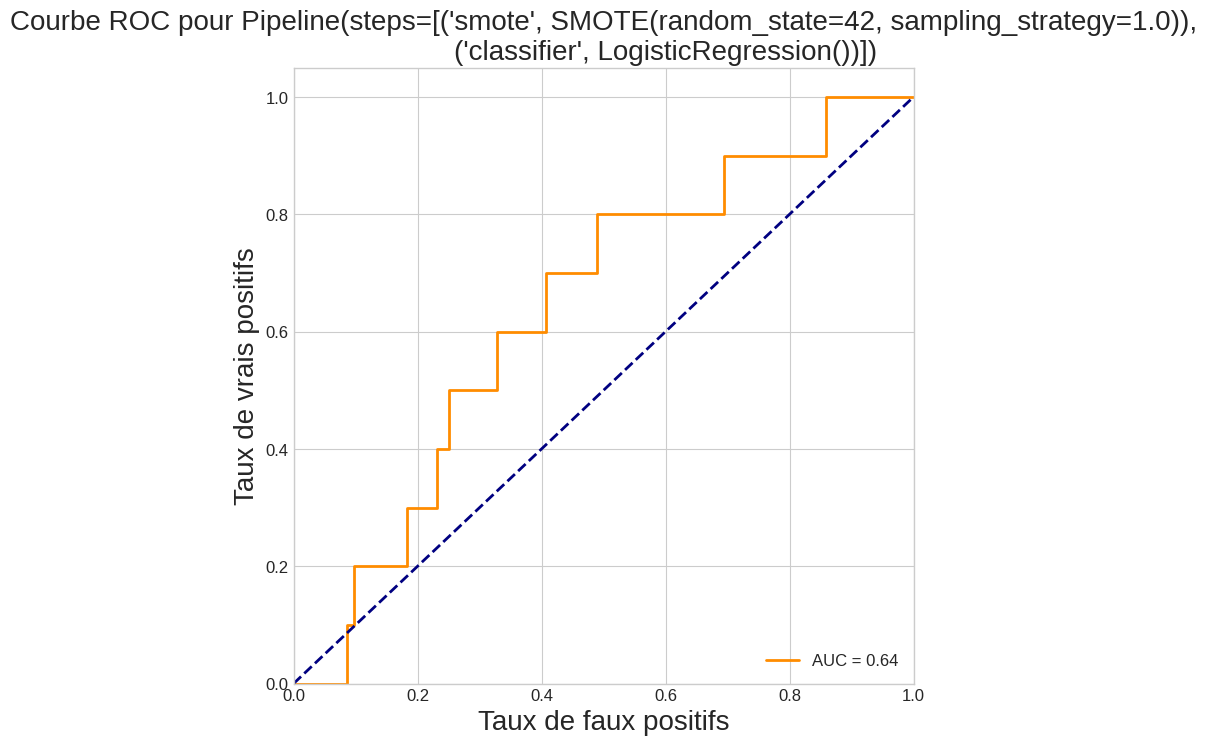

--------------------------------------------------
Meilleurs paramètres pour SVM: {'smote__sampling_strategy': 1.0}


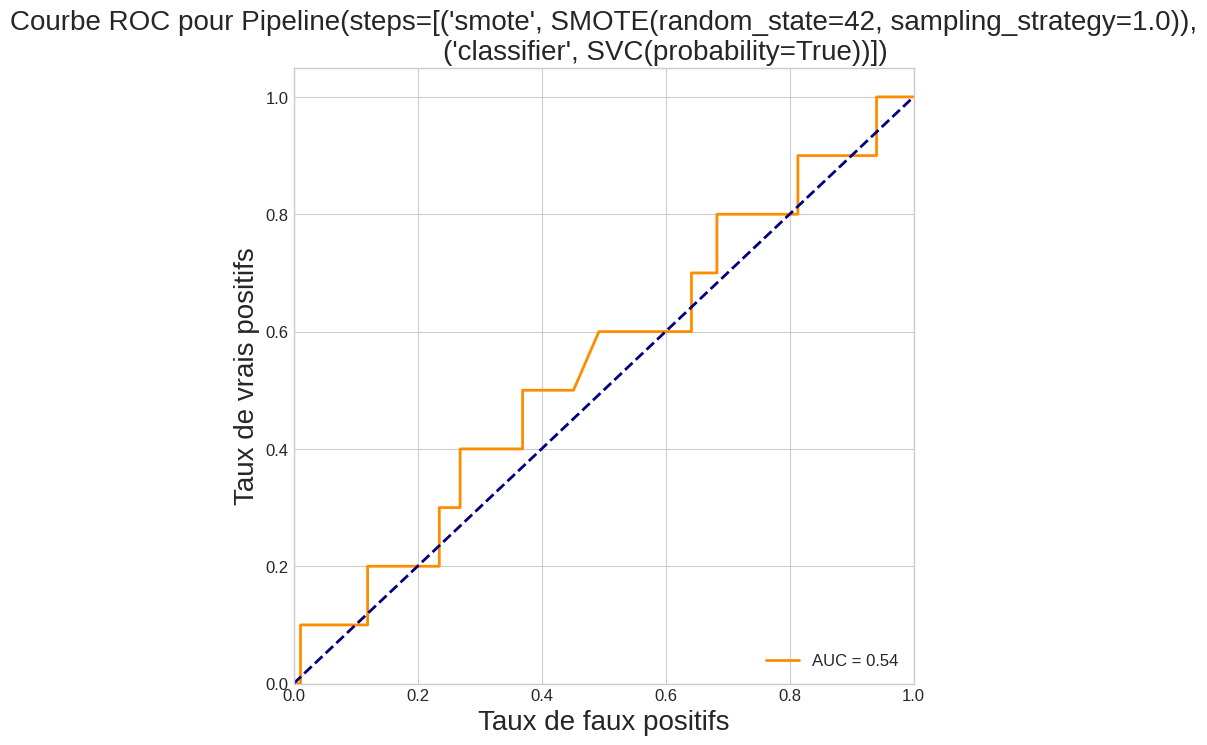

--------------------------------------------------
Meilleurs paramètres pour Random Forest: {'smote__sampling_strategy': 0.5}


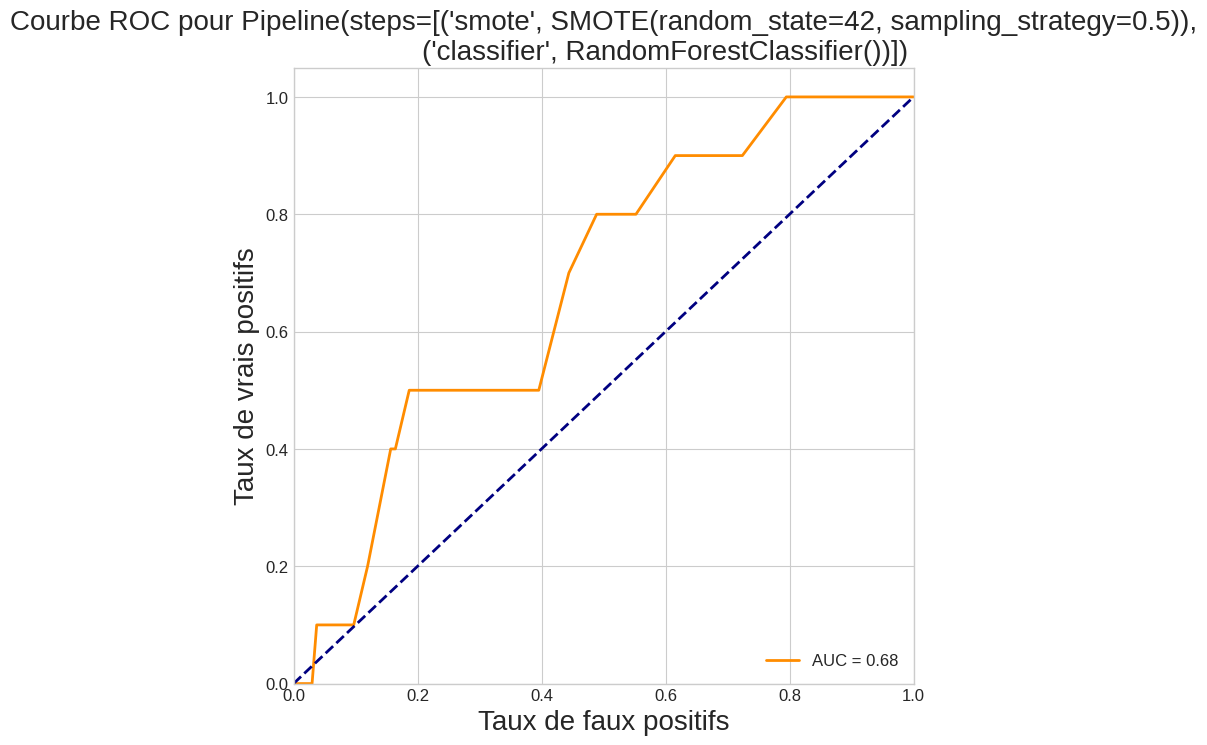

--------------------------------------------------
Meilleurs paramètres pour XGBoost: {'smote__sampling_strategy': 0.5}


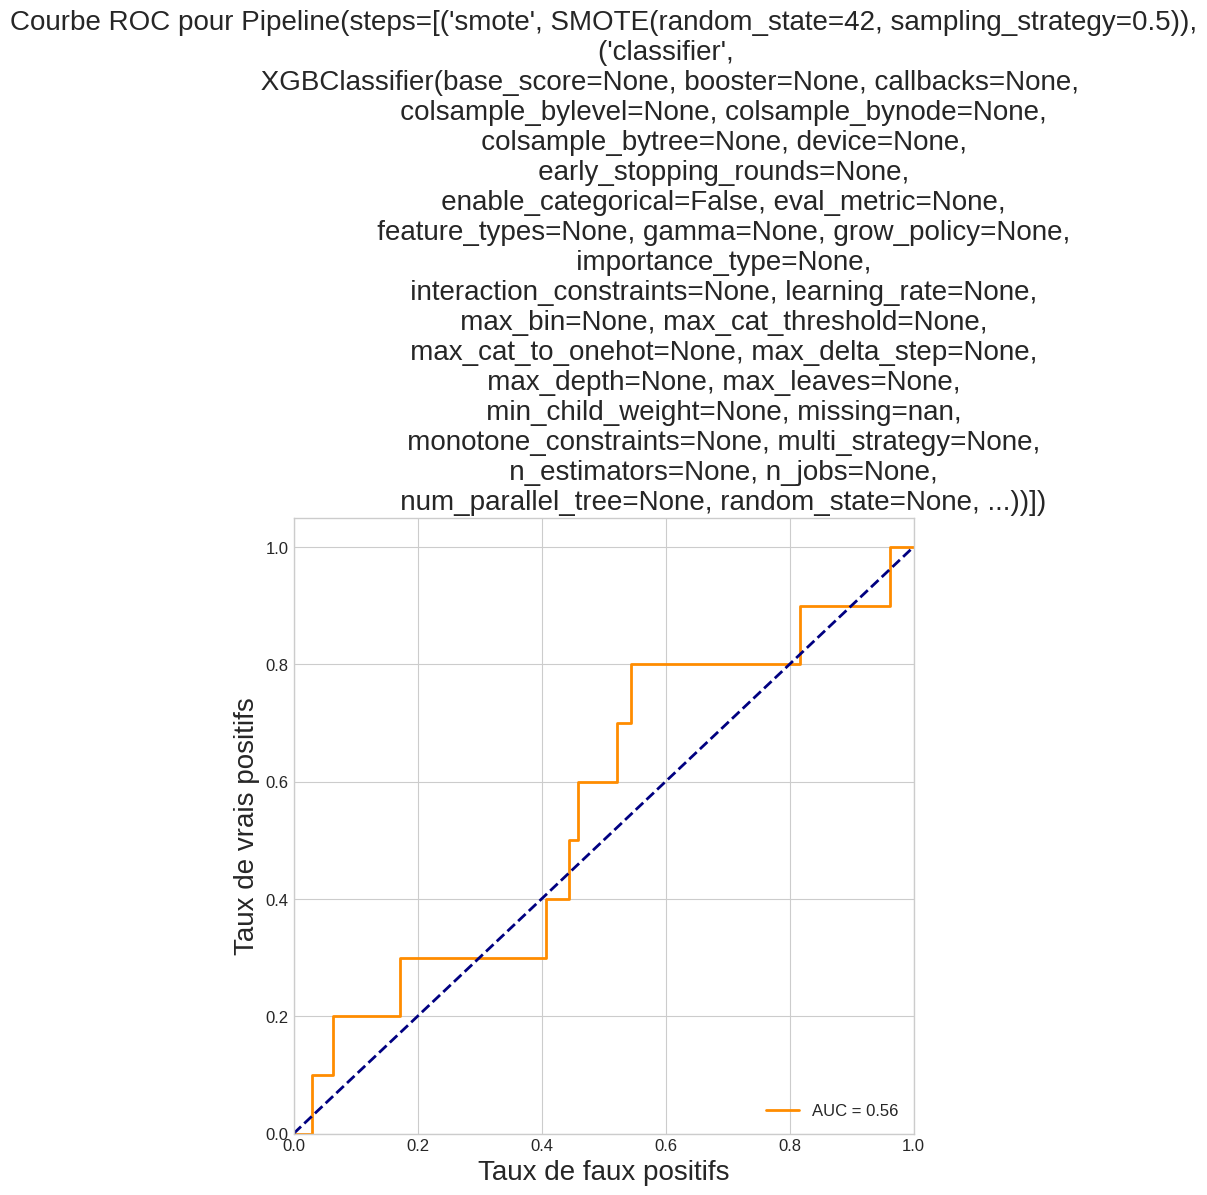

--------------------------------------------------


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Fonction pour afficher la courbe ROC et l'AUC
def roc_auc_curve(model, X_test, y_test):
    # Vérifier si le modèle peut calculer les probabilités
    if hasattr(model, 'predict_proba') and callable(getattr(model, 'predict_proba')):
        # Prédiction des probabilités
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Courbe ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Tracer la courbe ROC
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title(f'Courbe ROC pour {model}')
        plt.legend(loc="lower right")
        plt.show()

    else:
        print(f"Le modèle {model} ne prend pas en charge le calcul des probabilités.")

# Vos données X et y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèles à tester
models_to_test = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),  # Activer le calcul des probabilités
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

# Créer un pipeline avec SMOTE et le modèle à tester
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', None)  # Le modèle sera remplacé dans la boucle ci-dessous
])

# Paramètres pour la grille de recherche
param_grid = {
    'smote__sampling_strategy': [0.5, 0.75, 1.0],  # Ajustez selon vos besoins
}

# Boucle sur les modèles
for model_name, model in models_to_test.items():
    # Mettre à jour le modèle dans le pipeline
    pipeline.steps[-1] = ('classifier', model)

    # Initialiser la grille de recherche avec le pipeline
    grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=5)

    # Adapter le modèle avec les données d'entraînement
    grid_search.fit(X_train, y_train)

    # Afficher les meilleurs paramètres
    print(f"Meilleurs paramètres pour {model_name}: {grid_search.best_params_}")

    # Afficher la courbe ROC et l'AUC
    roc_auc_curve(grid_search.best_estimator_, X_test, y_test)

    print("-" * 50)


On peut alors choisir le modèle en fonction de toutes ces métriques

#Modèle choisi
On entraine mainteant le modèle XGBoost

In [22]:
# Entraîner le meilleur modèle avec toutes les données sans validation croisée
# J'ai choisi d'utiliser SMOTE même s'il n'y a pas de validation croisée car les données sont très déséquilibrées

smote = SMOTE(random_state=11)
X_train, y_train = smote.fit_resample(X_train, y_train)



In [23]:
# On entraîne nos données
classifier = XGBClassifier(alpha=0.001, booster="gblinear",
                           gamma=0, learning_rate=0.1,
                           max_depth=8, reg_lambda=0.5)
classifier.fit(X_train, y_train)

# On évalue le modèle sur l'ensemble de test et ajoute les résultats à un DataFrame
results = pd.DataFrame(columns=["name", "ROC", "PRECISION", "RECALL", "Score métier"])
results = evaluate_model_on_test("XGBoost", X_test, y_test, classifier, results)
results


,name,ROC,PRECISION,RECALL,Score métier
0,XGBoost,0.744403,0.06383,0.3,100.0


Prédiction sur les données test

In [24]:
# Predictions
print("Predictions sur les données test")
y_test_pred = classifier.predict(X_test)

print("Les 5 premires prédictions sur le jeux de données test")
print(y_test_pred[0:5])

print('score : ', classifier.score(X_test,y_test))

Predictions sur les données test
Les 5 premires prédictions sur le jeux de données test
[0 0 0 0 0]
score :  0.8165467625899281


In [25]:
# Commentaire sur l'importation de la bibliothèque collections
import collections

# Compter les occurrences de chaque classe dans y_test
collections.Counter(y_test)


Counter({0.0: 268, 1.0: 10})

In [26]:
# Compter les occurrences de chaque classe dans y_test_pred
collections.Counter(y_test_pred)

Counter({0: 231, 1: 47})

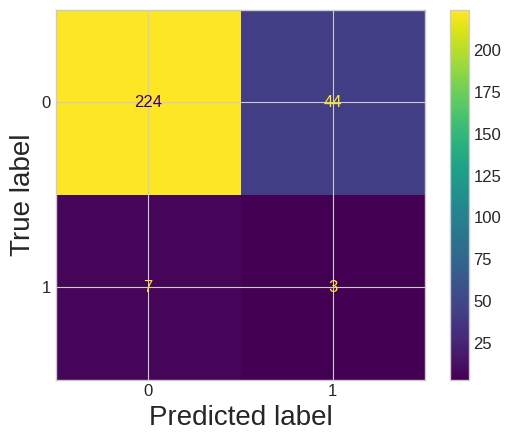

In [27]:
# Calculer et afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_test_pred)
display = ConfusionMatrixDisplay(conf_matrix)
display.plot()
plt.show()

Il y a 224 prêts qui ont été réellement remboursés et que le modèle a correctement prédit qu'ils seraient remboursés.

#Feature importance

La feature importance est une mesure de l'importance d'une caractéristique dans un modèle de machine learning. Elle permet de comprendre quelles caractéristiques sont les plus importantes pour la prise de décision du modèle.

Il existe de nombreuses méthodes pour calculer la feature importance. Une méthode courante consiste à utiliser les valeurs SHAP (SHapley Additive exPlanations). Les valeurs SHAP sont une mesure de l'impact d'une caractéristique sur la sortie d'un modèle.


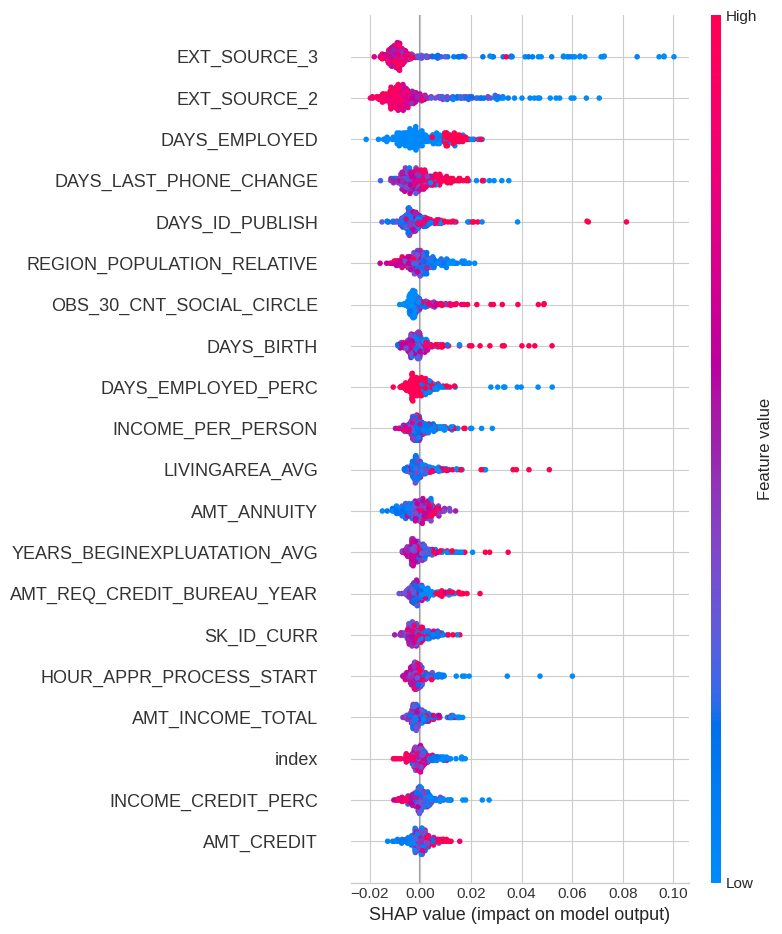

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import shap

# Assurez-vous que X est un DataFrame
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X)

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Suppression des colonnes non numériques pour simplifier l'exemple
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(exclude=['object']).columns

# Assurez-vous que vos données de test subissent le même traitement
X_train_numeric = X_train[numeric_columns]
X_test_numeric = X_test[numeric_columns]

# Créer un objet SimpleImputer avec la stratégie de votre choix (par exemple, la moyenne)
imputer = SimpleImputer(strategy='mean')

# Appliquer l'imputation sur l'ensemble d'entraînement
X_train_numeric_imputed = pd.DataFrame(imputer.fit_transform(X_train_numeric), columns=X_train_numeric.columns)

# Assurez-vous que vos données de test subissent le même traitement
X_test_numeric_imputed = pd.DataFrame(imputer.transform(X_test_numeric), columns=X_test_numeric.columns)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric_imputed)
X_test_scaled = scaler.transform(X_test_numeric_imputed)

# Appliquer le modèle RandomForestClassifier (best_model) sur les données imputées et normalisées
best_model = RandomForestClassifier()  # Assurez-vous de spécifier les paramètres nécessaires
best_model.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test_scaled)

# Utiliser SHAP pour expliquer les prédictions sur l'ensemble de test
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

# Afficher les valeurs SHAP pour une observation particulière (exemple : première observation)
shap.summary_plot(shap_values[1], X_test_scaled, feature_names=X_test_numeric.columns)



En regardant l'image, on peut voir que les caractéristiques les plus importantes pour prédire si un prêt sera remboursé sont :

EXT_SOURCE_3 : un score de crédit externe
EXT_SOURCE_2 : un autre score de crédit externe
DAYS_EMPLOYED : la durée d'emploi du demandeur

Ces caractéristiques sont toutes liées à la solvabilité du demandeur. Un score de crédit élevé indique que le demandeur est plus susceptible de rembourser son prêt. Une longue durée d'emploi indique que le demandeur a une source stable de revenus.

Les autres caractéristiques sont également importantes, mais elles ont un impact moindre sur la prédiction.
